# Lab Two for UW AMATH 563
## Assignment: MNIST Classification Task 
## By Rebecca Lopez

In [1]:
#Import Necessary Packages & Libraries
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch import nn
from math import floor, ceil
import random
import tqdm
import torchvision
import torch.nn.functional as F

Design your own MNIST Classification model (see video recording for explanation of MNIST dataset). You may choose your own hyperparameters, including:
- Number of layers
- Number of neurons in each layer
- Learning rate
- Number of training epochs
- Optimizer

Using a fully-connected network, you should be able to accomplish >90% accuracy on the test set. Please report your hyperparameter selections and accuracy in a summary at the end of the notebook.

To load the MNIST dataset, we will use `torchvision`, which contains the datasets and has useful transformations. Start by defining the batch size you want for your training and test sets

In [2]:
#Define train batch size
train_batch_size = 600 
#Define test batch size 
test_batch_size  = 200 
#Define validation batch size
valid_batch_size = 200

# Use the following code to load and normalize the dataset
MNIST_data = torch.utils.data.Subset( torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),random.sample(range(60000), 1000))


train_data, valid_data, test_data = torch.utils.data.random_split(MNIST_data, [train_batch_size, test_batch_size,valid_batch_size], generator=torch.Generator().manual_seed(1))

train_loader = torch.utils.data.DataLoader(dataset=train_data, shuffle=True,batch_size=train_batch_size)
test_loader = torch.utils.data.DataLoader(dataset=test_data, shuffle=False,batch_size=valid_batch_size)
valid_loader = torch.utils.data.DataLoader(dataset=valid_data, shuffle=False,batch_size=test_batch_size)

In [3]:
#Define network:
class Network(nn.Module):
    def __init__(self,input_dim,hidden_dim1,hidden_dim2,output_dim): 
    #Define the network layer(s) and activation function(s)
        super(Network, self).__init__()
        self.layer1 = nn.Linear(input_dim, hidden_dim1)
        self.layer2 = nn.Linear(hidden_dim1, hidden_dim2)
        self.layer3 = nn.Linear(hidden_dim2, output_dim)

    def forward(self, input):
        output = F.leaky_relu(self.layer1(input))
        output = F.relu(self.layer2(output))
        output = F.softmax(self.layer3(output), dim=1)
        return output

In [4]:
#Define hyperparameters
input_dim=784
hidden_dim1=50
hidden_dim2=50
output_dim=10
epochs = 250

#Define optimizer
model = Network(input_dim,hidden_dim1,hidden_dim2,output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

#Define loss function
loss_fn   = nn.CrossEntropyLoss()

loss_list     = np.zeros((epochs,))
accuracy_list = np.zeros((epochs,))

#Train network
for epoch in range(epochs):
    for train_sample in train_loader:
        
        input=train_sample[0]
        input=input.reshape(train_batch_size,1,input_dim)
        targets=train_sample[1]
        
        #Calculate training loss on model
        output = model(input)
        loss = loss_fn(output.squeeze(), targets)
        loss_list[epoch] = loss.item()

        # Zero gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    #Train on Validation
    for train_sample in valid_loader:
        train_X,train_Y= next(iter(valid_loader))
        input_train = train_X.reshape((valid_batch_size,input_dim))
        output_train = model(input_train)
        
        loss = loss_fn(output_train, train_Y)
        loss_list[epoch] = loss.item()
        
        # Zero gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #Validation
    with torch.no_grad():
        for valid_sample in valid_loader:
            valid_X,valid_Y = next(iter(valid_loader))
            input_valid=valid_X.reshape((valid_batch_size,input_dim))
            output_valid=model(input_valid)
            correct = (torch.argmax(torch.Tensor(output_valid), dim=1) == valid_Y).type(torch.FloatTensor)
            accuracy_list[epoch] = correct.mean()
print("Final Accuracy: "+str(correct.mean()))

Final Accuracy: tensor(0.9100)


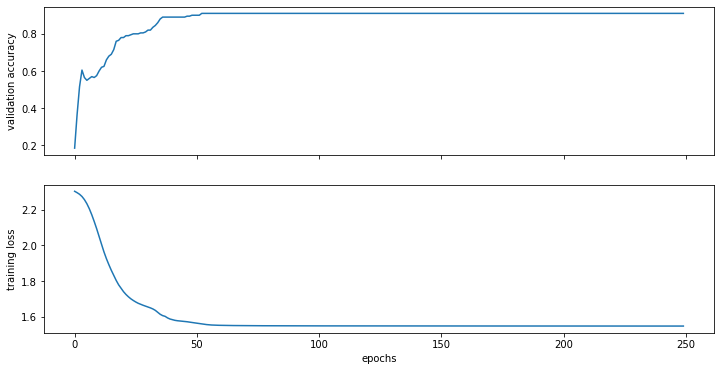

In [5]:
#Produce figure for training loss versus validation accuracy over epoch count
fig, (ax1, ax2) = plt.subplots(2, figsize=(12, 6), sharex=True)

ax1.plot(accuracy_list)
ax1.set_ylabel("validation accuracy")
ax2.plot(loss_list)
ax2.set_ylabel("training loss")
ax2.set_xlabel("epochs");

I mainly focused on varying the activation functions, training epochs, and learning rate by trying several values (3-4) within a range similar to the ones in the examples we had in class. I ended up with the following set of parameters:
<br>
1. Three hidden Layers
2. 50 neurons for each layer
3. Leakly ReLu, ReLu, and the Softmax activation function
4. 0.001 Learning Rate
5. 250 Epochs

Ultimately my final acurracy for my best model ended up being 0.9950 which is above the 90% requirement.